In [81]:
import numpy as np
import matplotlib.pyplot as plt
from fxpmath import Fxp
from scipy.signal import sawtooth

In [82]:
def generate_signal(signal_type, N, Fs):
    t = np.arange(N) / Fs
    x_real = np.zeros(N)
    x_imag = np.zeros(N)
    if signal_type == 'sin':
        F1 = 12.5e6
        x_real = np.sin(2 * np.pi * F1 * t)
    elif signal_type == 'pulse':
        x_real[0:2] = 1.0
    elif signal_type == 'random':
        x_real = 2 * np.random.rand(N) - 1
        x_imag = 2 * np.random.rand(N) - 1  
    elif signal_type == 'two_signals':
        F1 = 12.5e6
        F2 = 25e6
        signal = np.sin(2 * np.pi * F1 * t) + np.sin(2 * np.pi * F2 * t)
        x_real = signal / np.max(np.abs(signal))
    elif signal_type == 'sawtooth':
        F1 = 12.5e6
        signal = sawtooth(2 * np.pi * F1 * t)
        x_real = signal / np.max(np.abs(signal))
    else:
        print(f"Warning: Signal type '{signal_type}' not recognized. Generating zeros.")
        x_real = np.zeros(N)
    return x_real + 1j * x_imag

In [83]:
N = 4
Fs = 100e6
selected_signal_type = 'sin'
input_signal_float = generate_signal(selected_signal_type, N, Fs)
fft_numpy_reference = np.fft.fft(input_signal_float)

In [84]:
print(input_signal_float)

[0.        +0.j 0.70710678+0.j 1.        +0.j 0.70710678+0.j]


In [85]:
FXP_FORMAT_INPUT = 'fxp-s8/7'
FXP_FORMAT_MDC_OUTPUT = 'fxp-s10/7'

In [86]:
def cooley_tukey_fft4_fxp(signal_fxp, output_dtype):
    s0, s1, s2, s3 = signal_fxp[0], signal_fxp[1], signal_fxp[2], signal_fxp[3]
    y0 = s0 + s1 + s2 + s3
    y1 = s0 - 1j*s1 - s2 + 1j*s3
    y2 = s0 - s1 + s2 - s3
    y3 = s0 + 1j*s1 - s2 - 1j*s3
    transform_result_float = np.array([
        y0.get_val(), 
        y1.get_val(), 
        y2.get_val(), 
        y3.get_val()
    ])
    final_result_fxp = Fxp(transform_result_float, dtype=output_dtype, overflow='saturate', rounding='trunc')
    return final_result_fxp

In [87]:
input_signal_fxp = Fxp(input_signal_float, dtype=FXP_FORMAT_INPUT)
adjusted_output_fxp = cooley_tukey_fft4_fxp(input_signal_fxp, FXP_FORMAT_MDC_OUTPUT)

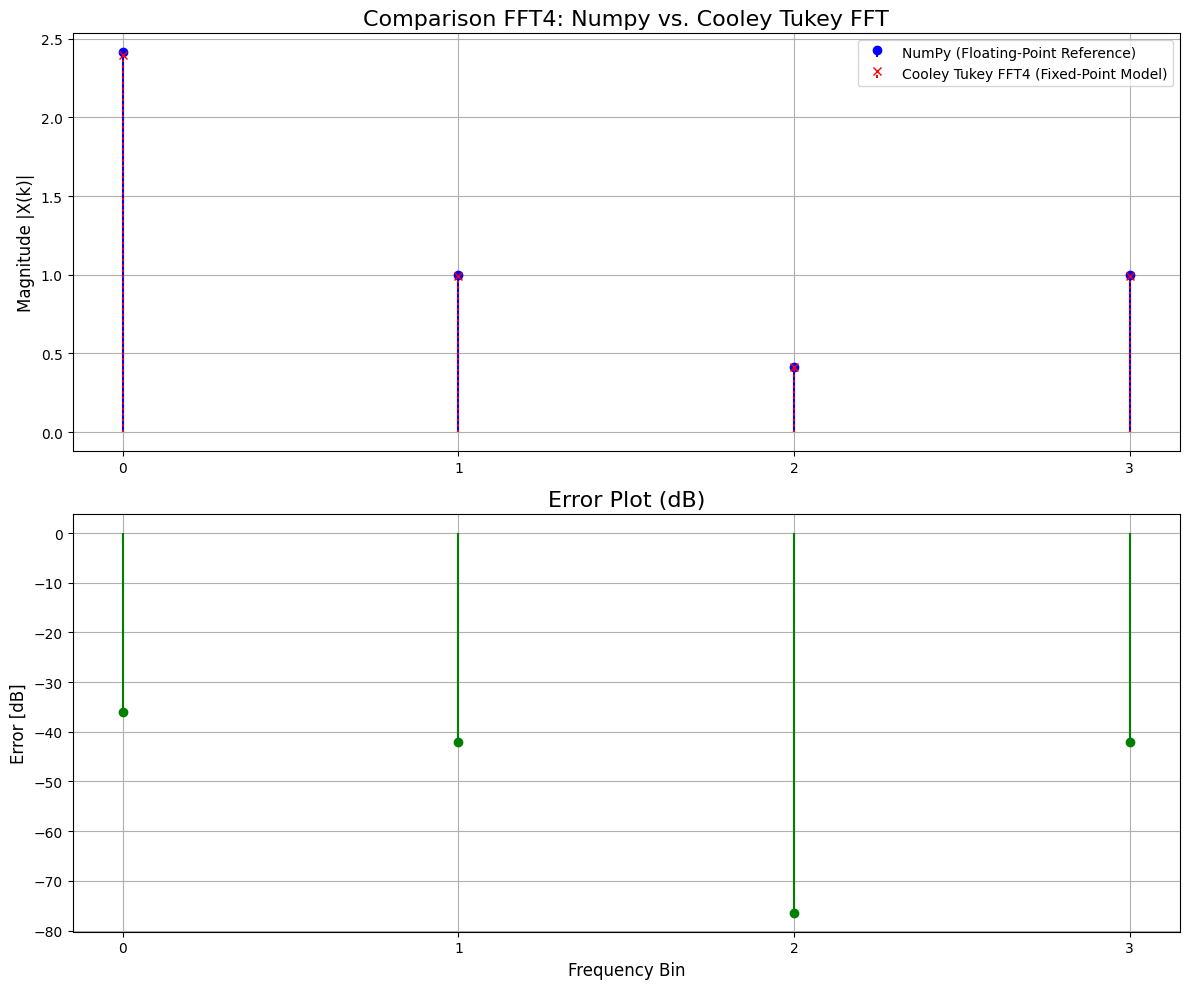

In [88]:
final_fxp_numpy = adjusted_output_fxp.get_val()

freq_bins = np.arange(N)
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].set_title('Comparison FFT4: Numpy vs. Cooley Tukey FFT', fontsize=16)
axs[0].stem(freq_bins, np.abs(fft_numpy_reference), 
            linefmt='b-', markerfmt='bo', basefmt=' ', 
            label='NumPy (Floating-Point Reference)')
axs[0].stem(freq_bins, np.abs(final_fxp_numpy), 
            linefmt='r:', markerfmt='rx', basefmt=' ',
            label=f'Cooley Tukey FFT4 (Fixed-Point Model)')

axs[0].set_ylabel('Magnitude |X(k)|', fontsize=12)
axs[0].set_xticks(freq_bins)
axs[0].legend()
axs[0].grid(True)

error_vector = fft_numpy_reference - final_fxp_numpy
epsilon = 1e-12
error_magnitude_db = 20 * np.log10(np.abs(error_vector) + epsilon)

axs[1].set_title('Error Plot (dB)', fontsize=16)
axs[1].stem(freq_bins, error_magnitude_db, 
            linefmt='g-', markerfmt='go', basefmt=' ')
axs[1].set_xlabel('Frequency Bin', fontsize=12)
axs[1].set_ylabel('Error [dB]', fontsize=12)
axs[1].set_xticks(freq_bins)
axs[1].grid(True)

plt.tight_layout()